In [25]:
#SEGMENTATIONChord

In [26]:
#Calculate Segments via Kernel Change Point Detection using Chord Information

In [27]:
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import librosa
import IPython.display as ipd
%matplotlib inline
from IPython.display import Audio
import ruptures as rpt
import sys
sys.path.append('..')

import matplotlib.gridspec as gridspec
import libfmp.b
import libfmp.c3
import pandas as pd

def fig_ax(figsize=(15, 5), dpi=150):
    """Return a (matplotlib) figure and ax objects with given size."""
    return plt.subplots(figsize=figsize, dpi=dpi)

In [28]:
name="../Output/journey/journey_"
path = "../" +"Data/journey/Journey - Gameplay  Playthrough (No Commentary)-[AudioTrimmer.com].mp3"

#name="../Output/mario/mario_"
#path = "../" +"Data/mario/Super Mario 64 [Part 1꞉ Bob-omb Battlefield] (No Commentary)-[AudioTrimmer.com].mp3"

#name="../Output/silenthill/silenthill_"
#path = "../" +"Data/silenthill/Silent Hill  Full UHD 4K  Longplay Walkthrough Gameplay No Commentary - 01.mp3"

x, Fs = librosa.load(path)
    
if len(x.shape) != 1:
    x = 0.5+(x[:, 0]+x[:, 1])

Audio(x, rate=Fs)

length_in_seconds = x.shape[0]/Fs
print('Sample rate: Fs=%0.0f Hz' % (Fs))
print('Length: %1d:%02d minutes' % (length_in_seconds//60, np.remainder(length_in_seconds, 60)))

Sample rate: Fs=22050 Hz
Length: 2:37 minutes


In [29]:
#chromagram

In [30]:
# estimate tuning
tuning_offset = librosa.estimate_tuning(y=x, sr=Fs, S=None, n_fft=4096, resolution=0.01, bins_per_octave=12)

print('tuning offset: '+str(tuning_offset))

# set chroma parameters
N = 4096
H = 2205
gamma = 100
norm_p = 2;

# compute chroma features with elliptic filter bank
P = librosa.iirt(y=x, sr=Fs, win_length=N, hop_length=H, center=True, tuning=tuning_offset)
C = librosa.feature.chroma_cqt(C=P, bins_per_octave=12, n_octaves=7, fmin=librosa.midi_to_hz(24), norm=norm_p)
# C = librosa.feature.chroma_cqt(y=x, bins_per_octave=12, n_octaves=7, fmin=librosa.midi_to_hz(24), norm=norm_p, tuning=tuning_offset)



tuning offset: 0.050000000000000044


In [31]:
def generate_template_matrix(templates):
    
    assert templates.shape[0] == 12, 'input "templatesC" has wrong size!'
    
    template_matrix = np.zeros((12, 12 * templates.shape[1]))

    for shift in range(12):
        template_matrix[:, shift::12] = np.roll(templates, shift, axis=0)

    return template_matrix


def analysis_template_match(f_chroma, templates, apply_normalization=True, norm_output='2'):
    
    assert templates.shape[0] == 12, 'input "f_chroma" has wrong size!'
    assert templates.shape[0] == 12, 'input "templates" has wrong size!'
    
    chroma_normalized = libfmp.c3.normalize_feature_sequence(f_chroma, norm='2')
    templates_normalized = libfmp.c3.normalize_feature_sequence(templates, norm='2')
    
    f_analysis = np.matmul(templates_normalized.T, chroma_normalized)
    if apply_normalization:
         f_analysis = libfmp.c3.normalize_feature_sequence(f_analysis, norm=norm_output)

    return f_analysis

# Plot chromagram
chroma_label = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

# Define templates
template_cmaj = np.array([[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]]).T
template_cmin = np.array([[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]]).T

templates_majmin = generate_template_matrix(np.concatenate((template_cmaj, template_cmin), axis=1))

# Define labels
chord_label_maj = chroma_label
chord_label_min = [s + 'm' for s in chroma_label]
chord_labels = chord_label_maj + chord_label_min


# Template-based chord recognition
f_analysis = analysis_template_match(C, templates_majmin, apply_normalization=True, norm_output='2')
chord_probs = f_analysis



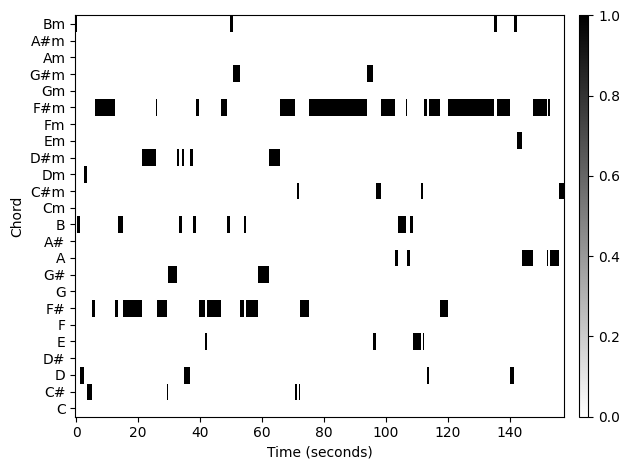

In [32]:

def fig_ax(figsize=(15, 5), dpi=150):
    """Return a (matplotlib) figure and ax objects with given size."""
    return plt.subplots(figsize=figsize, dpi=dpi)
from scipy import signal

# average filtering

filt_len = 31
down_sampling=5
C_filtered, Fs_smooth = libfmp.c3.smooth_downsample_feature_sequence(C, Fs=Fs/H, filt_len=filt_len, down_sampling=down_sampling)
C_filtered = libfmp.c3.normalize_feature_sequence(C_filtered, norm='2')
C_filtered_chords, down_samp_chords = C_filtered, down_sampling

f_analysis_prefilt = analysis_template_match(C_filtered, templates_majmin, apply_normalization=True, norm_output='2')
f_analysis_max_prefilt = (f_analysis_prefilt==f_analysis_prefilt.max(axis=0)).astype(int)
chords_filtered, filt_len_chords = f_analysis_max_prefilt, filt_len


gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.02])

H_down = H*down_sampling
ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])


libfmp.b.plot_matrix(f_analysis_max_prefilt, ax=[ax0, ax1], Fs=Fs/H_down, clim=[0, 1], ylabel='Chord', interpolation='none')
ax0.set_yticks(np.arange(24))
ax0.set_yticklabels(chord_labels)

plt.tight_layout()

plt.savefig(name + 'chordestimation.png')

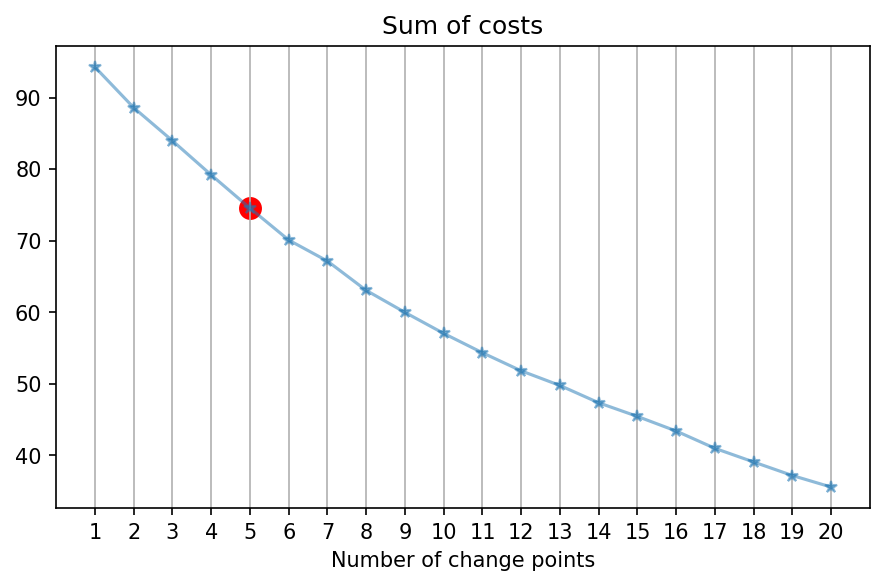

In [41]:

# Choose detection method
algo = rpt.KernelCPD(kernel="linear").fit(C_filtered_chords.T)

# Choose the number of changes (elbow heuristic)
n_bkps_max = 20  # K_max
# Start by computing the segmentation with most changes.
# After start, all segmentations with 1, 2,..., K_max-1 changes are also available for free.
_ = algo.predict(n_bkps_max)

array_of_n_bkps = np.arange(1, n_bkps_max + 1)


def get_sum_of_cost(algo, n_bkps) -> float:
    """Return the sum of costs for the change points `bkps`"""
    bkps = algo.predict(n_bkps=n_bkps)
    return algo.cost.sum_of_costs(bkps)


fig, ax = fig_ax((7, 4))
ax.plot(
    array_of_n_bkps,
    [get_sum_of_cost(algo=algo, n_bkps=n_bkps) for n_bkps in array_of_n_bkps],
    "-*",
    alpha=0.5,
)
ax.set_xticks(array_of_n_bkps)
ax.set_xlabel("Number of change points")
ax.set_title("Sum of costs")
ax.grid(axis="x")
ax.set_xlim(0, n_bkps_max + 1)

# Visually we choose n_bkps=5 (highlighted in red on the elbow plot): number of changes to detect
n_bkps = 5
_ = ax.scatter([5], [get_sum_of_cost(algo=algo, n_bkps=5)], color="r", s=100)

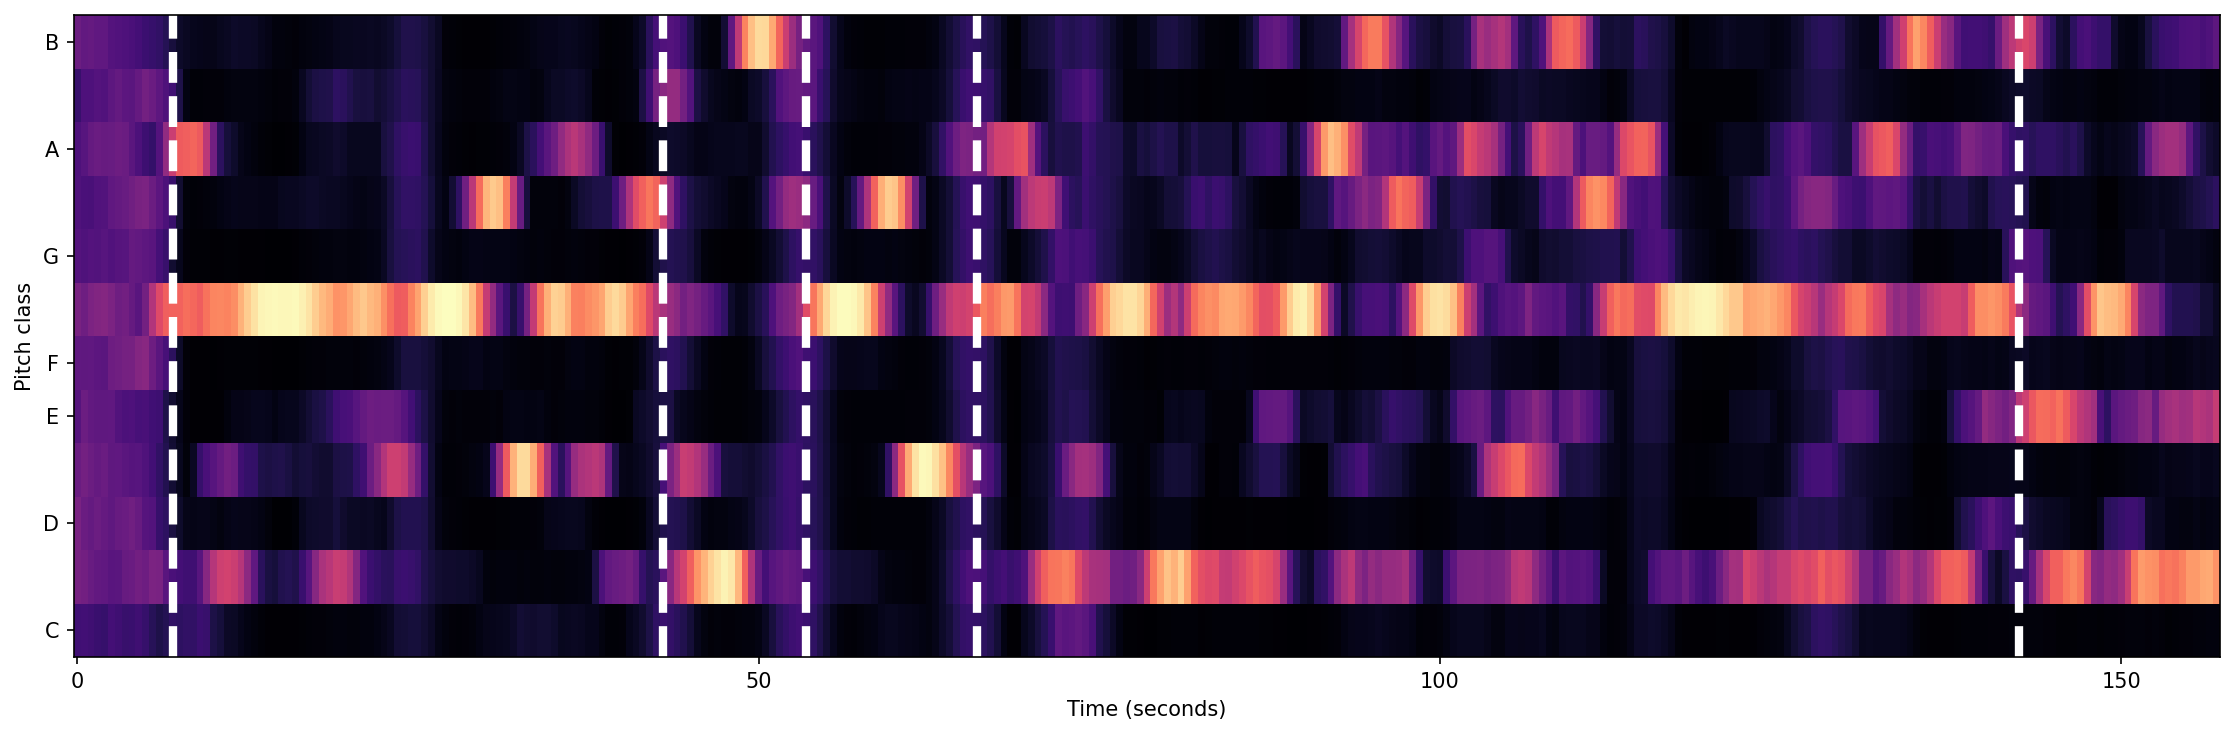

In [42]:


hop_length_chord= H_down
# Segmentation
bkps = algo.predict(n_bkps=n_bkps)
# Convert the estimated change points (frame counts) to actual timestamps
bkps_times = librosa.frames_to_time(bkps, sr=Fs, hop_length=hop_length_chord)

# Displaying results
fig, ax = fig_ax()
_ = librosa.display.specshow(
    C_filtered,
    ax=ax,
    x_axis="s",
    y_axis="chroma",
    hop_length=hop_length_tempo,
    sr=Fs,
)


for b in bkps_times[:-1]:
    ax.axvline(b, ls="--", color="white", lw=4)
    

plt.tight_layout()
plt.savefig(name + 'chordSegments.png')

In [47]:
# Compute change points corresponding indexes in original signal
bkps_time_indexes = (Fs * bkps_times).astype(int).tolist()

for segment_number, (start, end) in enumerate(
    rpt.utils.pairwise([0] + bkps_time_indexes), start=1
):
    segment = x[start:end]
    print(f"Segment n°{segment_number} (duration: {segment.size/Fs:.2f} s)")
    display(Audio(data=segment, rate=Fs))
    

Segment n°1 (duration: 7.00 s)


Segment n°2 (duration: 36.00 s)


Segment n°3 (duration: 10.50 s)


Segment n°4 (duration: 12.50 s)


Segment n°5 (duration: 76.50 s)


Segment n°6 (duration: 14.75 s)


In [44]:
# Convert seconds to "HH:MM:SS:MS"-format
def convert_to_time_format(seconds):
    hours = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    milliseconds = int((seconds - int(seconds)) * 100)
    return "{:02}:{:02}:{:02}:{:02}".format(int(hours), int(minutes), int(seconds), milliseconds)

# Convert "HH:MM:SS:MS"-format to seconds
def convert_to_seconds(timestring):
    hours, minutes, seconds, milliseconds = map(int, timestring.split(':'))
    return hours * 3600 + minutes * 60 + seconds + milliseconds / 100


# Save data as DataFrame
df = pd.DataFrame(bkps_times, columns=["end_ts"])

# Add new columns
df = df.assign(segment_id=np.arange(1, len(df) + 1),
               segmentation_name="audio-chord-segmentation")

# Rename the "start_ts" column to "end_ts" and apply conversion function
df["end_ts"] = df["end_ts"].apply(convert_to_time_format)

# Create the "start_ts" column
df["start_ts"] = df["end_ts"].shift(fill_value=convert_to_time_format(0))

# Create the "duration_ts" column
df["duration_ts"] = (df["end_ts"].apply(convert_to_seconds) - df["start_ts"].apply(convert_to_seconds)).apply(convert_to_time_format)

# Rearrange columns
df = df[["segment_id", "segmentation_name", "start_ts", "end_ts", "duration_ts"]]

# Save DataFrame to a CSV file
df.to_csv(name + "bkps_timesChord.csv", index=True)